# 01 - Field reflectance analysis

This notebook loads, clean and visualices field reflectance data from different types of soil and vegetation. 

The data was obtained using the FieldSpec® 3 portable spectroradiometer. This instrument integrates three sensors, enabling measurements across a wide spectral range—from the visible to the near-infrared regions. It features precision optics with 25° and 10° field-of-view options and a fiber optic cable for collecting spectral data under different conditions. The device is equipped with a backpack for field use, a handheld probe for precise targeting, and dedicated software for instrument control and data analysis. Measurements are referenced against a Spectralon panel, which serves as a calibration target with near-100% reflectance.

Spectroradiometer sensor specifications:

| Sensor | Wavelength Range (nm) | Spectral Resolution (nm) | Sampling Interval (nm) |
|---------|------------------------|---------------------------|------------------------|
| NIR     | 400–1000               | 3                         | 1.4                    |
| SWIR1   | 1000–1800              | 10                        | 2                      |
| SWIR2   | 1800–2400              | 10                        | 2                      |



The objective of this exercise is to measure the spectral signature of different materials in the visible and near-infrared regions.

This notebook is organized to visualize and analyze field reflectance data from different types of soils, vegetation, and surfaces. The workflow is divided into several sections:


1. **Imports and setup**  
   All necessary Python packages and custom functions from `src/signatures_processing.py` are loaded here. The project folder is added to the Python path so the notebook can access the data and functions.



In [4]:
# Import the required libraries and codes from the project

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
from pathlib import Path

# Add project root to sys.path
root_path = Path(__file__).resolve().parent.parent if '__file__' in globals() else Path('../').resolve()
if str(root_path) not in sys.path:
    sys.path.append(str(root_path))

from src.signatures_processing import load_signatures_for_object


2. **Raw spectral signatures**  
   This section plots the mean spectral signatures of all objects directly from the raw measurement files. No cleaning or masking of bad bands is applied, and the reflectance is limited between 0 and 1 for proper visualization. The legend is omitted to keep the figure uncluttered.



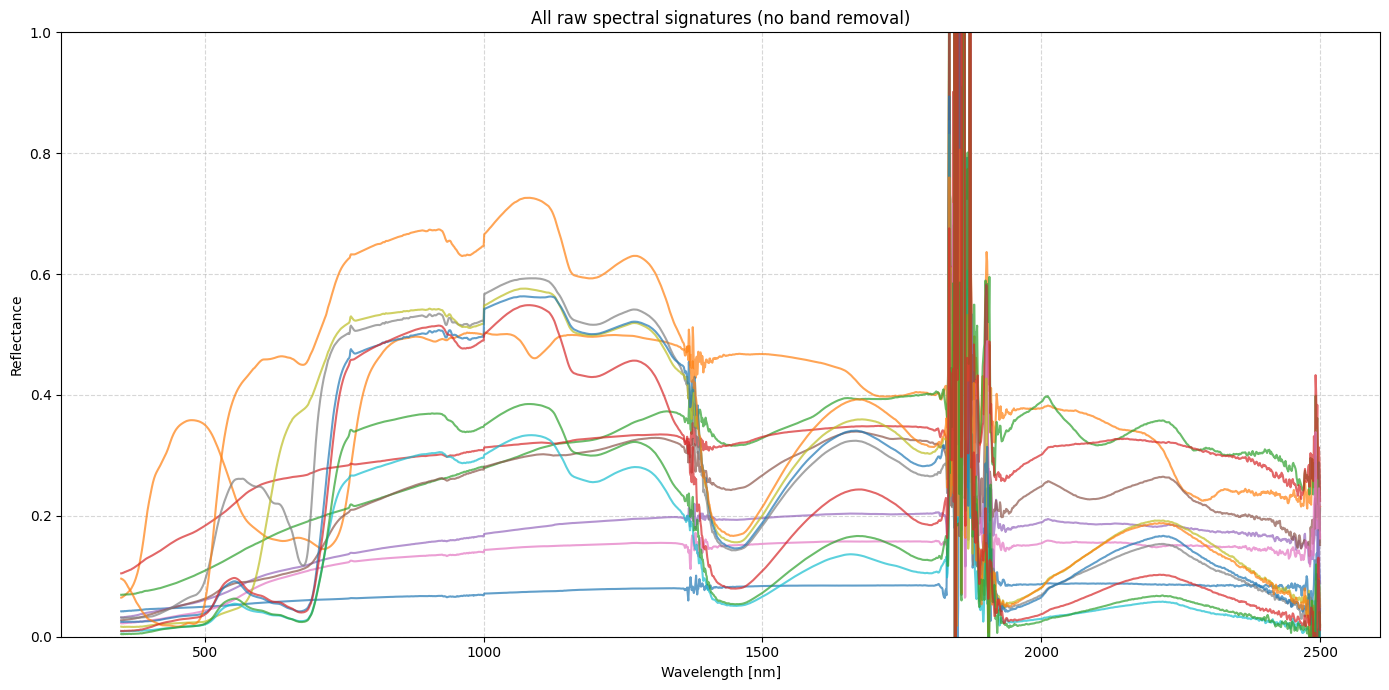

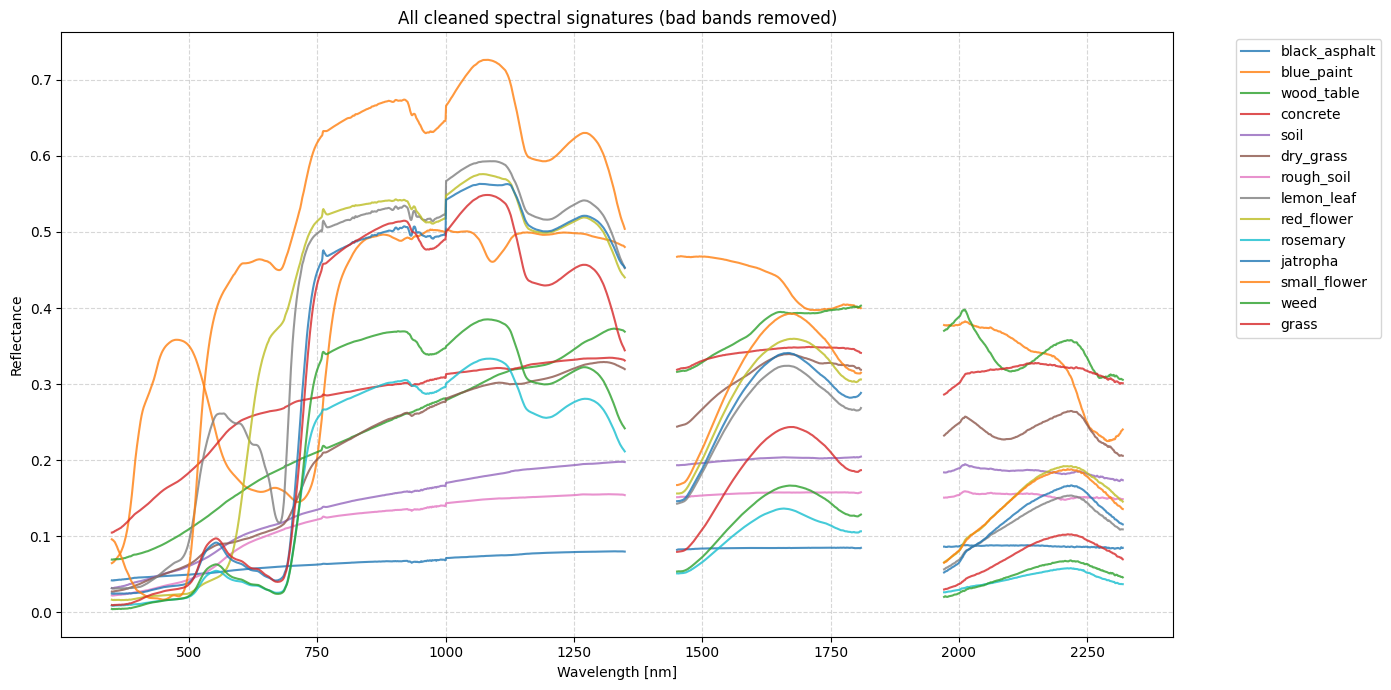

In [5]:

data_folder = Path('../data/field')

# Define all categories and objects
categories = {
    'surfaces': ['black_asphalt', 'blue_paint', 'wood_table', 'concrete'],
    'soils': ['soil', 'dry_grass', 'rough_soil'],
    'vegetation': ['lemon_leaf', 'red_flower', 'rosemary', 'jatropha', 'small_flower', 'weed', 'grass']
}

# Plot all raw signatures (without cleaning)
plt.figure(figsize=(14, 7))
for cat, objs in categories.items():
    for obj in objs:
        wl, mean_refl = load_signatures_for_object(data_folder, obj, clean=False)
        if wl is not None and mean_refl is not None:
            plt.plot(wl, mean_refl, alpha=0.7)
plt.title("All raw spectral signatures (no band removal)")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Reflectance")
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Plot all cleaned signatures (with bad bands removed)
plt.figure(figsize=(14, 7))
for cat, objs in categories.items():
    for obj in objs:
        wl, mean_refl = load_signatures_for_object(data_folder, obj, clean=True)
        if wl is not None and mean_refl is not None:
            plt.plot(wl, mean_refl, label=obj, alpha=0.8)
plt.title("All cleaned spectral signatures (bad bands removed)")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Reflectance")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




3. **Cleaned spectral signatures and category plots**  
   Here, the spectral data is processed using the `apply_mask` function to remove noisy or invalid bands (e.g., atmospheric absorption regions).  
   - First, all cleaned signatures are plotted together with a legend.  
   - Then, separate plots for each category (surfaces, soils, vegetation) are generated to allow detailed inspection and comparison between objects within the same group.

By structuring the notebook this way, the workflow ensures a clear comparison between raw and cleaned data, while providing an easy-to-interpret visualization of spectral signatures across different material types.


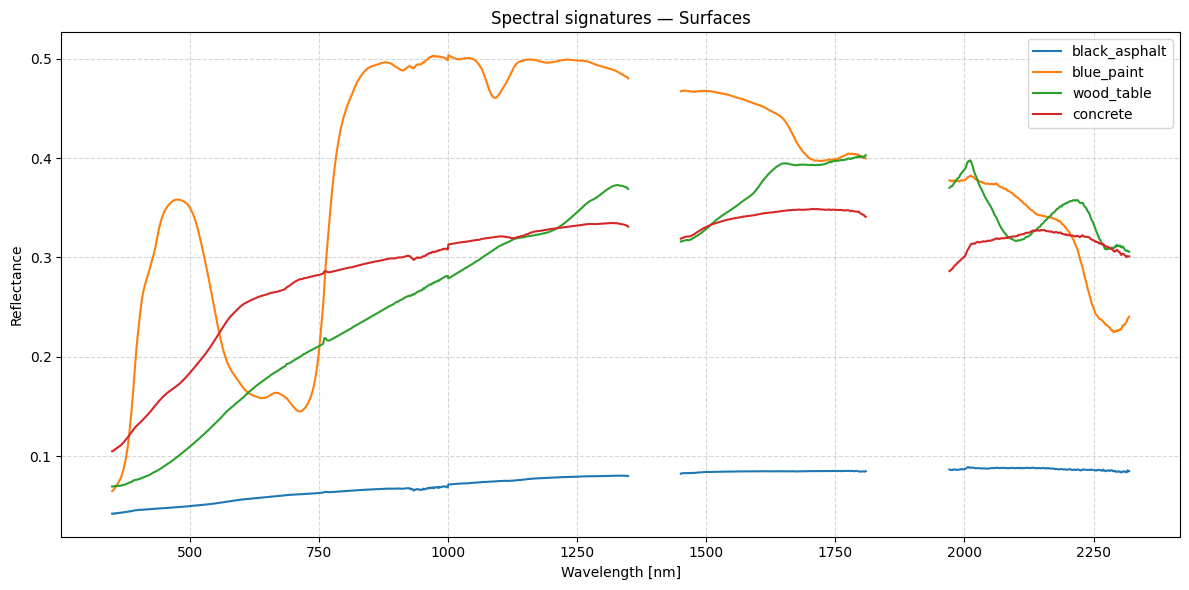

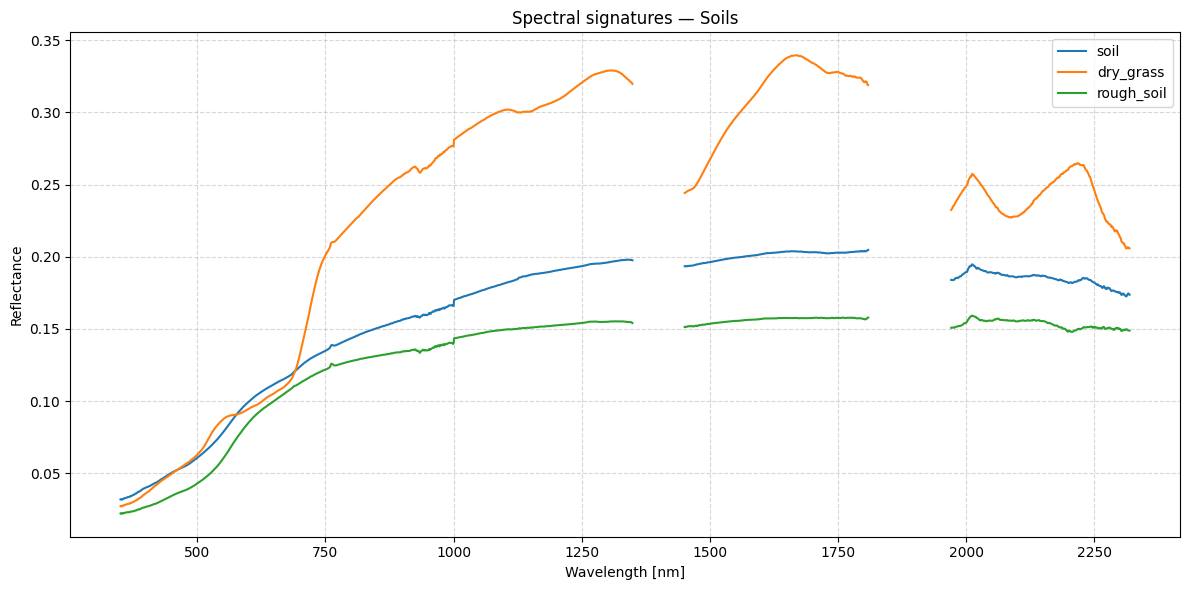

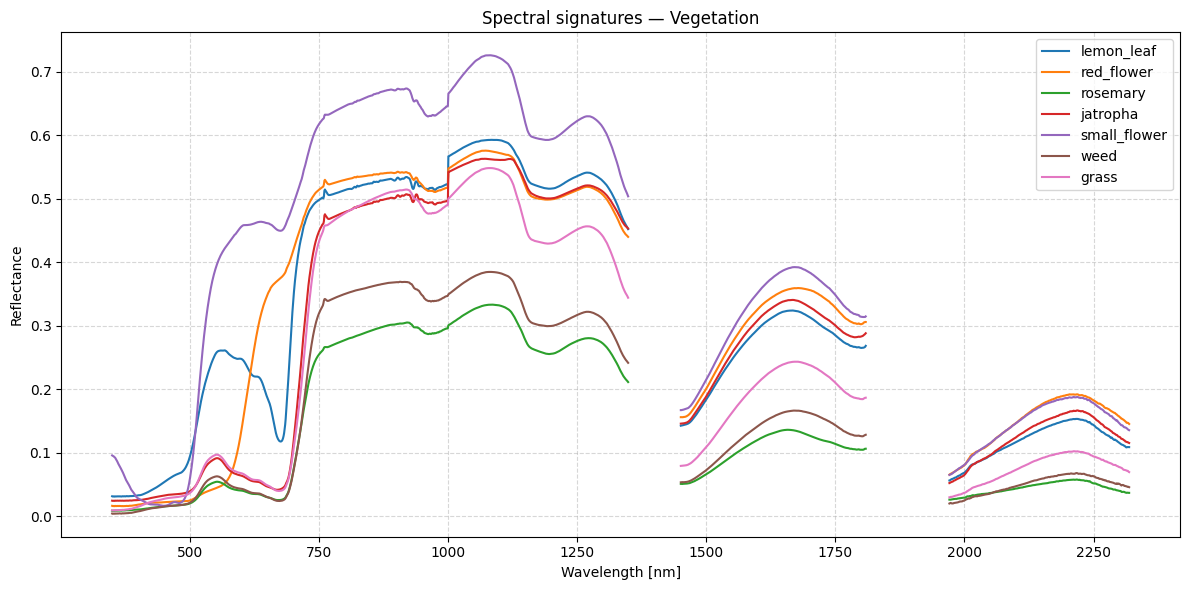

In [6]:
# Plot by category
def plot_category(category_name, object_list):
    plt.figure(figsize=(12, 6))
    for obj in object_list:
        wl, mean_refl = load_signatures_for_object(data_folder, obj, clean=True)
        if wl is not None:
            plt.plot(wl, mean_refl, label=obj)
    plt.title(f"Spectral signatures — {category_name.capitalize()}")
    plt.xlabel("Wavelength [nm]")
    plt.ylabel("Reflectance")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Plot each group
for cat, objs in categories.items():
    plot_category(cat, objs)
